In [1]:
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from __future__ import print_function
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# MACCS Fingerprint
from rdkit.Chem import MACCSkeys
import moses
from tqdm.auto import tqdm
from random import sample
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw



from rdkit.Chem import DataStructs
#from rdkit.ML.Cluster import Butina

In [8]:
train_df = pd.read_csv('split_data/trainset_by_cluster.csv')

In [2]:
pred_df = pd.read_csv('split_data/prediction_testset_by_cluster_719.csv') 

pred_df # 132584 rows × 3 columns

,npy_path,smiles_pred,smiles
0,/gxr/Omics/CIL/24623-npy/24623_BRD-K60343011-0...,C1CCC[C@@H](C)Oc2c(cc(cc2)NC(=O)Nc2ccc(cc2)F)C...,C[C@@H](CO)N1C[C@H](C)[C@H](CN(C)C(=O)C2CCC2)O...
1,/gxr/Omics/CIL/24623-npy/24623_BRD-K59099936-0...,c1cc(ccc1)CC(N(C)C[C@@H]1Oc2c(cc(cn2)C#CCCC)C(...,COc1ccc(NC(=O)N(C)C[C@H]2Oc3cc(ccc3S(=O)(=O)N(...
2,/gxr/Omics/CIL/24623-npy/24623_BRD-K06361641-0...,c1cc(ccc1)CC(N(C[C@@H]1Oc2ncc(cc2C(N([C@@H](CO...,C[C@@H](CO)N1C[C@H](C)[C@@H](CN(C)C(=O)Cc2ccnc...
3,/gxr/Omics/CIL/24623-npy/24623_BRD-K51004501-0...,c1cc(ccc1)CC(=O)N(C)C[C@@H]1Oc2ncc(cc2C(N([C@@...,C[C@H](CO)N1C[C@@H](C)[C@@H](CN(C)CC2CC2)Oc2cc...
4,/gxr/Omics/CIL/24623-npy/24623_BRD-K59099936-0...,C1CCC[C@@H](C)Oc2ccc(cc2C(=O)N([C@@H](CO)C)C[C...,COc1ccc(NC(=O)N(C)C[C@H]2Oc3cc(ccc3S(=O)(=O)N(...
...,...,...,...
132579,/gxr/Omics/CIL/26745-npy/26745_BRD-K40597283-0...,c1cc(ccc1)[C@@H]1[C@@H](N(C(=O)C2CCOCC2)[C@H]1...,CO[C@H](CN(C)C(=O)c1cnccn1)[C@@H](C)CN([C@@H](...
132580,/gxr/Omics/CIL/26745-npy/26745_BRD-K63279176-0...,c1cc(ccc1)CCNC(=O)C[C@@H]1C[C@@H]2[C@@H]([C@@H...,CO[C@@H](CN(C)S(=O)(=O)c1ccc(F)cc1)[C@H](C)CN(...
132581,/gxr/Omics/CIL/26745-npy/26745_BRD-K43963447-0...,c1cc(ccc1-c1ccc(cc1)-c1cc(ccc1)-c1cc(ccc1)-c1c...,CO[C@@H](CN(C)Cc1ccc2OCOc2c1)[C@@H](C)CN([C@@H...
132582,/gxr/Omics/CIL/26745-npy/26745_BRD-K17863985-0...,c1cc(ccc1)[C@@H]1[C@@H](CO)[C@@H]2N([C@@H]1c1n...,CO[C@@H](CN(C)C(=O)Nc1ccc(F)cc1)[C@H](C)CN(Cc1...


In [3]:
print(len(pred_df['smiles'])) 
print(len(pred_df['smiles'].unique())) # 5625
print(len(pred_df['smiles_pred']))
print(len(pred_df['smiles_pred'].unique())) # 6952

132584
5625
132584
6952


In [5]:
# 1. check valid proportion
from IPython.utils import io


def filter_valid_smiles():
    #pred_df = df_pred_3channels

    mols_pred =[]
    index_valid_mols = []
    invalid_smiles = []
    valid_smiles = []
    fps_pred = []

    l = list(pred_df['smiles_pred']) #list(pred_df['smiles_pred'].unique())

    for index,smi in enumerate(tqdm(l)):
        try:
            m = Chem.MolFromSmiles(smi)
            fp = MACCSkeys.GenMACCSKeys(m)

        except:
            invalid_smiles.append(smi)
            continue
        fps_pred.append(fp)
        index_valid_mols.append(index)
        mols_pred.append(m)
        valid_smiles.append(smi)

        
with io.capture_output() as captured:
    filter_valid_smiles()

In [8]:
print(len(valid_smiles))
print(len(invalid_smiles))
print(len(fps_pred))
print('valid percent:', (1 - len(invalid_smiles)/132584)*100)

113340
19244
113340
valid percent: 85.48542810595548


In [9]:
# Now let's only evaluate those VALID PREDICTIONS
pred_df_sliced = pred_df.iloc[index_valid_mols]
pred_df = pred_df_sliced # 132584 -> 113340
print(pred_df.shape) 

(113340, 3)


In [10]:
print(len(pred_df['smiles'])) 
print(len(pred_df['smiles'].unique())) # 5623
print(len(pred_df['smiles_pred']))
print(len(pred_df['smiles_pred'].unique())) # 5788

113340
5623
113340
5788


In [12]:
smiles_pred_l = list(pred_df['smiles_pred'])
smiles_label_l = list(pred_df['smiles'])

new_smiles_pred_l = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in tqdm(smiles_pred_l)]
new_smiles_label_l = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in tqdm(smiles_label_l)]

In [13]:
pred_df['smiles_pred'] = new_smiles_pred_l
pred_df['smiles'] = new_smiles_label_l

<ipython-input-13-ee9aa4ba5514>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['smiles_pred'] = new_smiles_pred_l
<ipython-input-13-ee9aa4ba5514>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['smiles'] = new_smiles_label_l


In [14]:
print(len(pred_df['smiles'])) 
print(len(pred_df['smiles'].unique())) # 5623
print(len(pred_df['smiles_pred']))
print(len(pred_df['smiles_pred'].unique())) # 3909

113340
5623
113340
3909


In [33]:
# calculate Morgan fingerprints
# Predicted, 画tsne图时需要unique
mols_pred =[]
l = list(pred_df['smiles_pred'])
#l = sample(l,3000)
print(len(l))

for smi in tqdm(l): #list(pred_df['smiles'].unique()):
    m = Chem.MolFromSmiles(smi)
    mols_pred.append(m)

fps_pred = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(mols_pred)]

# Label
mols_org =[]
l = list(pred_df['smiles'])
#l = sample(l,3000)
print(len(l))

for smi in tqdm(l): #list(pred_df['smiles'].unique()):
    m = Chem.MolFromSmiles(smi)
    mols_org.append(m)

#print(len(list(pred_df['smiles'].unique())))
fps_label = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(mols_org)]


113340



113340


In [9]:
# Training Morgan FP, SAMPLE 6000 molecules

mols_train =[]
l = list(train_df['smiles'].unique())
#print(len(l))
l = sample(l , 6000)
print(len(l))
for smi in tqdm(l): #list(pred_df['smiles'].unique()):
    m = Chem.MolFromSmiles(smi)
    mols_train.append(m)

#print(len(list(pred_df['smiles'].unique())))
fps_train = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(mols_train)]
print(len(fps_train))

6000



6000


In [ ]:
# calculate MACCS fingerprints -> LATER

In [10]:
X_train = np.array(fps_train)

In [11]:
X_label = np.array(fps_label)

In [12]:
X_pred = np.array(fps_pred)

In [20]:
X_all = np.concatenate((X_train, X_label), axis=0)
print(X_train.shape)
print(X_label.shape)
print(X_pred.shape)
print(X_all.shape)

(6000, 2048)
(5623, 2048)
(5788, 2048)
(11623, 2048)


In [14]:
#do PCA and TSNE together
pca_model = PCA(n_components=20, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=3000, verbose=True)

In [21]:
#tsne_pca_drugs_all = tsne_model.fit_transform(pca_model.fit_transform(X_all))
tsne_pca_drugs_all = pca_model.fit_transform(X_all)
print('finished')

finished


<function matplotlib.pyplot.show(close=None, block=None)>

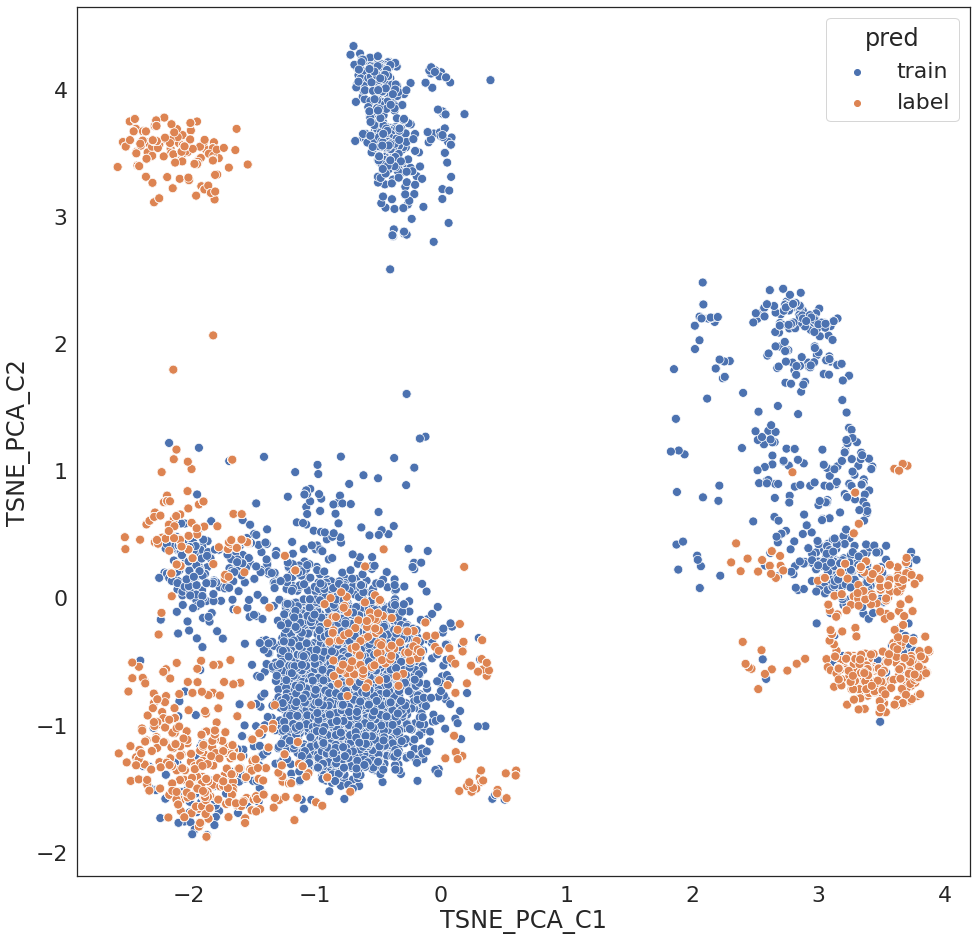

In [22]:
df_all_plot = pd.DataFrame(tsne_pca_drugs_all.T[0])
df_all_plot['TSNE_PCA_C1'] = tsne_pca_drugs_all.T[0]
df_all_plot['TSNE_PCA_C2'] = tsne_pca_drugs_all.T[1]
#pred_class = ['train'] * 3000 + ['label'] * 3000 + ['pred'] * 2845
pred_class =  ['train'] * 6000 + ['label'] * 5623

df_all_plot['pred'] = pred_class

plt.figure(figsize=(16, 16))
sns.set(font_scale=2) 
sns.set_style("white")
sns.scatterplot(data=df_all_plot, x="TSNE_PCA_C1", y="TSNE_PCA_C2"#, palette='viridis'
                , hue = 'pred', s=80)
plt.show

In [25]:
# Morgan similarity
sm_l = []
for i in tqdm(range(len(fps_pred))):
    fp1 = fps_pred[i]
    fp2 = fps_label[i]
    sm= DataStructs.TanimotoSimilarity(fp1,fp2) #DataStructs.FingerprintSimilarity(fp1,fp2)
                                         #,metric=DataStructs.DiceSimilarity)
    #print("similarity between mol 1 and mol2: %.2f"%sm)
    sm_l.append(sm)
#print("similarity between mol 1 and mol2: %.2f"%sm01)
print(len(sm_l))
pred_df['Morgan'] = sm_l


113340


<ipython-input-25-bfecc4431d7e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Morgan'] = sm_l


<function matplotlib.pyplot.show(close=None, block=None)>

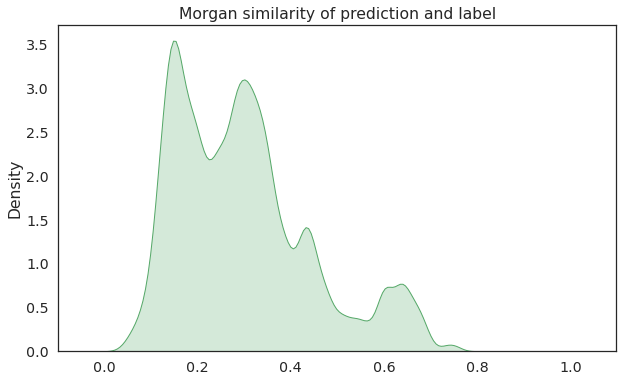

In [26]:
sns.set(font_scale=1.3) 
sns.set_style("white")
fig = plt.figure(figsize=(10,6))
x = list(pred_df['Morgan'])
sns.kdeplot(x,shade=True,color="g",palette = 'bright').set_title("Morgan similarity of prediction and label")
plt.show

In [30]:
import copy
sm_max_l = []
for fp in tqdm(fps_pred):
    l_compare = copy.deepcopy(fps_pred)
    l_compare.remove(fp)
    
    l_compare = sample(l_compare, 1000)
    similarity_l = []
    for fp_compare in l_compare:
        similarity = DataStructs.TanimotoSimilarity(fp,fp_compare)
        similarity_l.append(similarity)
    sm_max = max(similarity_l)
    sm_max_l.append(sm_max)
print(len(sm_max_l))
sns.set(font_scale=1.3) 
sns.set_style("white")
fig = plt.figure(figsize=(10,6))
x = sm_max_l
sns.kdeplot(x,shade=True,color="g",palette = 'bright').set_title("Morgan similarity of prediction set itself")
plt.show

KeyboardInterrupt: 

In [35]:
# Calculate 5 qualities and plot
mol_list_1 = mols_pred
mol_list_2 = mols_org

# FOR predictions:
tpsa_m_l = []
logp_m_l = []
hba_l = []
hbd_l = []
mw_l = []
for m in tqdm(mol_list_1):
    tpsa_m=Descriptors.TPSA(m)
    logp_m=Descriptors.MolLogP(m)
    hba = Descriptors.NumHAcceptors(m)
    hbd = Descriptors.NumHDonors(m)
    mw = Descriptors.MolWt(m)
    
    hba_l.append(hba)
    hbd_l.append(hbd)
    mw_l.append(mw)
    tpsa_m_l.append(tpsa_m)
    logp_m_l.append(logp_m)
    

pred_df['hba_pred'] = hba_l
pred_df['hbd_pred'] = hbd_l
pred_df['mw_pred'] = mw_l
pred_df['logp_pred'] = logp_m_l
pred_df['tpsa_pred'] = tpsa_m_l



# FOR labels:
tpsa_m_l = []
logp_m_l = []
hba_l = []
hbd_l = []
mw_l = []

for m in tqdm(mol_list_2):
    tpsa_m=Descriptors.TPSA(m)
    logp_m=Descriptors.MolLogP(m)
    hba = Descriptors.NumHAcceptors(m)
    hbd = Descriptors.NumHDonors(m)
    mw = Descriptors.MolWt(m)
    
    hba_l.append(hba)
    hbd_l.append(hbd)
    mw_l.append(mw)
    tpsa_m_l.append(tpsa_m)
    logp_m_l.append(logp_m)

pred_df['hba_label'] = hba_l
pred_df['hbd_label'] = hbd_l
pred_df['mw_label'] = mw_l
pred_df['logp_label'] = logp_m_l
pred_df['tpsa_label'] = tpsa_m_l
pred_df

<ipython-input-35-8c2a333f7274>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['hba_pred'] = hba_l
<ipython-input-35-8c2a333f7274>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['hbd_pred'] = hbd_l
<ipython-input-35-8c2a333f7274>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

<ipython-input-35-8c2a333f7274>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['hba_label'] = hba_l
<ipython-input-35-8c2a333f7274>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['hbd_label'] = hbd_l
<ipython-input-35-8c2a333f7274>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,npy_path,smiles_pred,smiles,Morgan,hba_pred,hbd_pred,mw_pred,logp_pred,tpsa_pred,hba_label,hbd_label,mw_label,logp_label,tpsa_label
0,/gxr/Omics/CIL/24623-npy/24623_BRD-K60343011-0...,C1CCC[C@@H](C)Oc2c(cc(cc2)NC(=O)Nc2ccc(cc2)F)C...,C[C@@H](CO)N1C[C@H](C)[C@H](CN(C)C(=O)C2CCC2)O...,0.298077,6,3,558.695,4.82680,103.37,6,1,557.713,3.08250,107.46
1,/gxr/Omics/CIL/24623-npy/24623_BRD-K59099936-0...,c1cc(ccc1)CC(N(C)C[C@@H]1Oc2c(cc(cn2)C#CCCC)C(...,COc1ccc(NC(=O)N(C)C[C@H]2Oc3cc(ccc3S(=O)(=O)N(...,0.336449,5,1,477.605,3.15440,82.97,6,2,557.713,4.02530,108.41
2,/gxr/Omics/CIL/24623-npy/24623_BRD-K06361641-0...,c1cc(ccc1)CC(N(C[C@@H]1Oc2ncc(cc2C(N([C@@H](CO...,C[C@@H](CO)N1C[C@H](C)[C@@H](CN(C)C(=O)Cc2ccnc...,0.382353,5,1,477.605,3.01030,82.97,6,1,527.687,3.50870,100.04
3,/gxr/Omics/CIL/24623-npy/24623_BRD-K51004501-0...,c1cc(ccc1)CC(=O)N(C)C[C@@H]1Oc2ncc(cc2C(N([C@@...,C[C@H](CO)N1C[C@@H](C)[C@@H](CN(C)CC2CC2)Oc2cc...,0.295238,5,1,477.605,3.15440,82.97,6,1,483.634,3.33568,93.87
4,/gxr/Omics/CIL/24623-npy/24623_BRD-K59099936-0...,C1CCC[C@@H](C)Oc2ccc(cc2C(=O)N([C@@H](CO)C)C[C...,COc1ccc(NC(=O)N(C)C[C@H]2Oc3cc(ccc3S(=O)(=O)N(...,0.327103,6,3,558.695,4.82680,103.37,6,2,557.713,4.02530,108.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132577,/gxr/Omics/CIL/26745-npy/26745_BRD-K22629238-0...,c1cc(ccc1-c1ccc(cc1)-c1ccc(cc1)-c1cccc(c1)-c1c...,CO[C@H](CN(C)Cc1cc(F)ccc1F)[C@H](C)CN([C@H](C)...,0.177215,3,1,589.779,10.01530,32.70,5,1,484.609,3.42782,70.08
132578,/gxr/Omics/CIL/26745-npy/26745_BRD-K17566112-0...,C1CCCC(C1)NC(=O)C[C@@H]1O[C@@H](CO)[C@@H]2[C@@...,CO[C@@H](CN(C)C(=O)c1ccccc1F)[C@H](C)CN([C@H](...,0.090000,5,3,442.556,3.25860,96.89,5,1,466.575,2.62050,87.15
132579,/gxr/Omics/CIL/26745-npy/26745_BRD-K40597283-0...,c1cc(ccc1)[C@@H]1[C@@H](N(C(=O)C2CCOCC2)[C@H]1...,CO[C@H](CN(C)C(=O)c1cnccn1)[C@@H](C)CN([C@@H](...,0.151163,4,1,300.358,1.29208,73.56,7,1,450.561,1.27140,112.93
132580,/gxr/Omics/CIL/26745-npy/26745_BRD-K63279176-0...,c1cc(ccc1)CCNC(=O)C[C@@H]1C[C@@H]2[C@@H]([C@@H...,CO[C@@H](CN(C)S(=O)(=O)c1ccc(F)cc1)[C@H](C)CN(...,0.113208,6,3,454.523,2.01490,106.12,6,1,537.075,2.82240,104.22


In [ ]:
# for training

Text(0.5, 1.0, 'Molecular Weight')

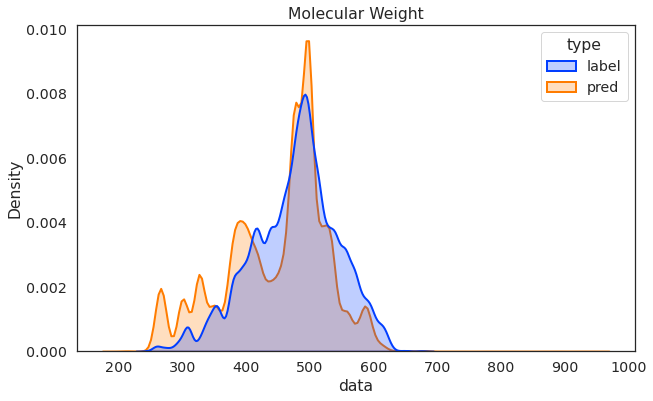

In [38]:
# MW
sns.set(font_scale=1.3) 
sns.set_style("white")
fig = plt.figure(figsize=(10,6))
x = list(pred_df['mw_label'])
y = list(pred_df['mw_pred'])
#x2 = list(train_df['mw_pred'])
z = x + y #+ x2
df_plot = pd.DataFrame(z)
df_plot['data'] = z
type_l = ['label'] * len(x) + ['pred'] * len(y) #+ ['train'] * len(x2)
df_plot['type'] = type_l


sns.kdeplot(data=df_plot, x="data", hue="type", fill=True, common_norm=False, 
            palette = 'bright', 
            linewidth = 2)
#fig.legend(labels=['tpsa_Label','tpsa_Predicted'])
plt.title("Molecular Weight")